Link on Research Gate: https://www.researchgate.net/publication/370690271_Machine_Learning_and_Deep_Learning_methods_for_music_genre_Classification

# Library import

In [ ]:
import numpy as np 
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
import os
from tqdm import tqdm
import librosa
from librosa.feature import mfcc
from IPython.display import display, clear_output
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

D0511 20:06:52.405903085    3987 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0511 20:06:52.405949623    3987 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0511 20:06:52.405953567    3987 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0511 20:06:52.405956410    3987 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0511 20:06:52.405958936    3987 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0511 20:06:52.405961722    3987 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0511 20:06:52.405965213    3987 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0511 20:06:52.

In [ ]:
import keras
import numpy as np
import librosa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Reshape,TimeDistributed, Lambda,BatchNormalization, InputLayer,AveragePooling2D,GlobalAvgPool2D, Input
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Load Audio Files Paths

In [ ]:
#files 
genre_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
file_path = [os.path.join(genre_path,x) for x in os.listdir(genre_path)]
genres = [x for x in os.listdir(genre_path)]

In [ ]:
audio_paths = []
for i in tqdm(file_path):
    for j in os.listdir(i):
        file = os.path.join(i,j)
        audio_paths.append(file)



100%|██████████| 10/10 [00:00<00:00, 1339.78it/s]


# Audio Data Processing Functions

In [ ]:
def get_segments(audio, sr, segment_duration):
    segment_samples = segment_duration * sr
    audio_length = len(audio)
    n_segments = audio_length // segment_samples
    
    # truncate audio to make it evenly divisible into segments
    audio = audio[:n_segments * segment_samples]
    
    # reshape audio into segments
    segments = audio.reshape(n_segments, segment_samples)
    
    return segments

def extract_mfccs(audio_path, n_mfcc=13, n_fft=2048, hop_length=512, sr=22050):
    audio, sr = librosa.load(audio_path, sr=22050)

    segments = get_segments(audio, sr, segment_duration=3)
    segment_mfccs = []
    for segment in segments:
        mfcc = librosa.feature.mfcc(y=segment, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, sr=sr)
        segment_mfccs.append(mfcc)
    return segment_mfccs

# MFCCs

In [ ]:
# generate Data for model
data = []
labels = []
for path in audio_paths:
    genre = path.split('/')[6]
    try:
        fmccs = extract_mfccs(path)
        clear_output(wait=True)
        for frame in fmccs:
            data.append(frame)
            labels.append(genre)
    except Exception:
        pass

/tmp/ipykernel_3987/2185731227.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=22050)
/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


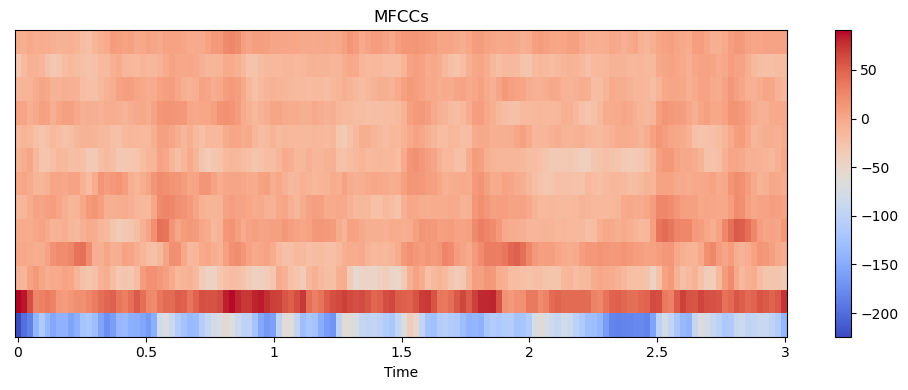

In [ ]:
# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(data[0], x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()


In [ ]:

# check if data and label have same length since the above function fails to load some audio files
assert len(data) == len(labels)

In [ ]:
def reshape(data,shape=(26,65)):
    assert data.shape == (13,130) , f"The Data shape should be (13,130) but got {data.shape}"
    data = data.reshape(shape)
    data = np.expand_dims(data,axis=-1)
    return data

In [ ]:
processed_data = np.array([reshape(x) for x in data])

In [ ]:
# convert text labels to int 
from sklearn.preprocessing import LabelEncoder
lbenc = LabelEncoder()
labels = lbenc.fit_transform(labels)


In [ ]:
classes = lbenc.classes_

In [ ]:
# split the data for training and testing
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(processed_data,labels,test_size=0.2,
                                               shuffle=True,random_state=42)

In [ ]:
len(processed_data)

9981

## CNN with 2 convolutional layers

In [ ]:
model1 = models.Sequential([
    layers.Input(shape=(26, 65, 1)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='valid', activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='valid', activation='relu'),
    layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='valid', activation='relu'),
    layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
    layers.Conv2D(filters=512, kernel_size=(4, 4), padding='valid', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 63, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 61, 256)       590080    
                                                                 
 average_pooling2d (AverageP  (None, 11, 31, 256)      0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 29, 256)        590080    
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 15, 256)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 12, 512)        2

In [ ]:
# set up a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
history = model1.fit(X_train,y_train,batch_size=16,epochs=100,validation_data=(X_val, y_val),callbacks =[checkpoint])

Epoch 1/100
498/499 [============================>.] - ETA: 0s - loss: 1.6614 - accuracy: 0.3924
Epoch 1: val_accuracy improved from -inf to 0.43315, saving model to best_model.h5
499/499 [==============================] - 12s 14ms/step - loss: 1.6603 - accuracy: 0.3930 - val_loss: 1.4880 - val_accuracy: 0.4331
Epoch 2/100
497/499 [============================>.] - ETA: 0s - loss: 1.3261 - accuracy: 0.5119
Epoch 2: val_accuracy improved from 0.43315 to 0.52228, saving model to best_model.h5
499/499 [==============================] - 7s 13ms/step - loss: 1.3256 - accuracy: 0.5123 - val_loss: 1.3042 - val_accuracy: 0.5223
Epoch 3/100
495/499 [============================>.] - ETA: 0s - loss: 1.1559 - accuracy: 0.5785
Epoch 3: val_accuracy improved from 0.52228 to 0.60240, saving model to best_model.h5
499/499 [==============================] - 6s 13ms/step - loss: 1.1581 - accuracy: 0.5779 - val_loss: 1.0815 - val_accuracy: 0.6024
Epoch 4/100
498/499 [============================>.] - ET

In [ ]:
best_model = keras.models.load_model('best_model.h5')

In [ ]:
pred = best_model.predict(X_val)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(y_val,preds,average='micro')
accuracy = accuracy_score(y_val,preds)
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")

63/63 [==============================] - 0s 6ms/step
The Test Accuracy is 0.8392588883324987 
 The F1 Score is 0.8392588883324987


In [ ]:
print(classification_report(y_val ,preds,target_names=classes))

              precision    recall  f1-score   support

       blues       0.84      0.88      0.86       192
   classical       0.95      0.93      0.94       194
     country       0.76      0.76      0.76       198
       disco       0.82      0.77      0.79       208
      hiphop       0.84      0.87      0.86       197
        jazz       0.81      0.95      0.87       205
       metal       0.88      0.91      0.89       204
         pop       0.90      0.84      0.87       173
      reggae       0.80      0.80      0.80       189
        rock       0.82      0.71      0.76       237

    accuracy                           0.84      1997
   macro avg       0.84      0.84      0.84      1997
weighted avg       0.84      0.84      0.84      1997



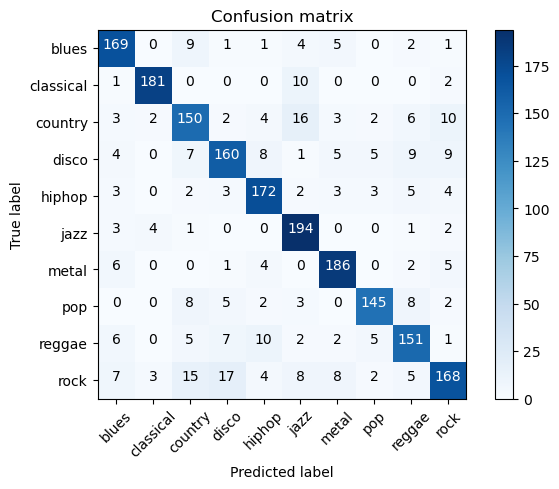

In [ ]:
cm = confusion_matrix(y_val,preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

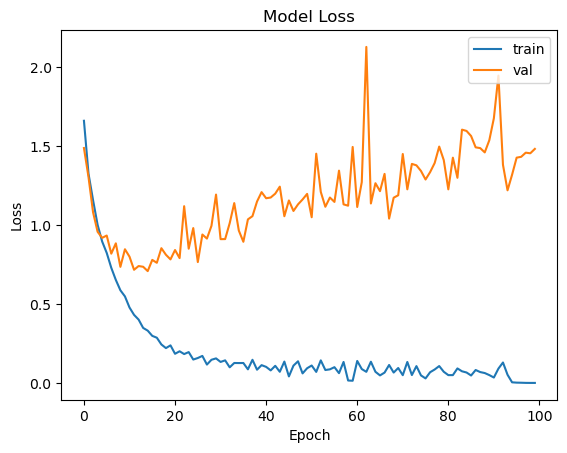

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

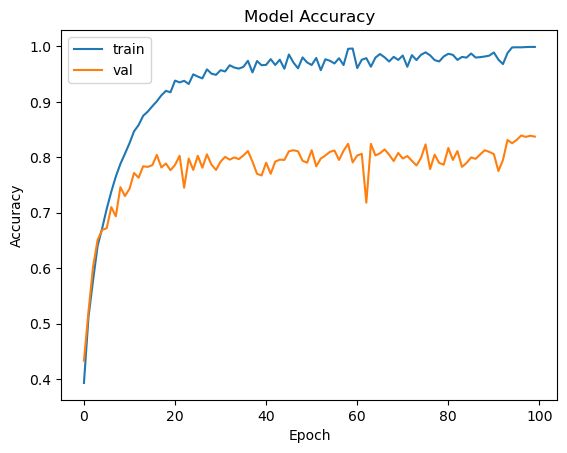

In [ ]:
# plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## CNN WITH REDUCED CONVOLUTIONAL LAYERS

In [ ]:
model2 = models.Sequential([
    layers.Input(shape=(26, 65, 1)),
    layers.Conv2D(filters=256, kernel_size=3, padding='valid', activation='relu'),
    layers.AveragePooling2D(pool_size=3, strides=2, padding='same'),
    layers.Conv2D(filters=512, kernel_size=3, padding='valid', activation='relu'),
    layers.AveragePooling2D(pool_size=3, strides=2, padding='same'),
    layers.Conv2D(filters=128, kernel_size=4, padding='valid', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 24, 63, 256)       2560      
                                                                 
 average_pooling2d_14 (Avera  (None, 12, 32, 256)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_31 (Conv2D)          (None, 10, 30, 512)       1180160   
                                                                 
 average_pooling2d_15 (Avera  (None, 5, 15, 512)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_32 (Conv2D)          (None, 2, 12, 128)        1048704   
                                                                 
 global_average_pooling2d_10  (None, 128)            

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])
model2.summary ()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 24, 63, 256)       2560      
                                                                 
 average_pooling2d_14 (Avera  (None, 12, 32, 256)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_31 (Conv2D)          (None, 10, 30, 512)       1180160   
                                                                 
 average_pooling2d_15 (Avera  (None, 5, 15, 512)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_32 (Conv2D)          (None, 2, 12, 128)        1048704   
                                                                 
 global_average_pooling2d_10  (None, 128)            

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
# Train model
history=model2.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val),callbacks=[checkpoint])

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 1.7342 - accuracy: 0.3831
Epoch 1: val_accuracy improved from -inf to 0.43866, saving model to best_model.h5
250/250 [==============================] - 7s 16ms/step - loss: 1.7342 - accuracy: 0.3831 - val_loss: 1.4429 - val_accuracy: 0.4387
Epoch 2/100
249/250 [============================>.] - ETA: 0s - loss: 1.3860 - accuracy: 0.4965
Epoch 2: val_accuracy improved from 0.43866 to 0.54482, saving model to best_model.h5
250/250 [==============================] - 3s 13ms/step - loss: 1.3851 - accuracy: 0.4969 - val_loss: 1.2783 - val_accuracy: 0.5448
Epoch 3/100
246/250 [============================>.] - ETA: 0s - loss: 1.2322 - accuracy: 0.5544
Epoch 3: val_accuracy improved from 0.54482 to 0.55083, saving model to best_model.h5
250/250 [==============================] - 3s 13ms/step - loss: 1.2322 - accuracy: 0.5539 - val_loss: 1.2387 - val_accuracy: 0.5508
Epoch 4/100
246/250 [============================>.] - ETA

In [ ]:
best_model = keras.models.load_model('/kaggle/input/reduced-cnn2/REDUCED_CNN_MFCS_2.h5')

In [ ]:
pred = best_model.predict(X_val)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(y_val,preds,average='micro')
accuracy = accuracy_score(y_val,preds)
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")

63/63 [==============================] - 0s 4ms/step
The Test Accuracy is 0.799699549323986 
 The F1 Score is 0.799699549323986


In [ ]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
print(classification_report(y_val,p#reds,target_names=classes))

              precision    recall  f1-score   support

       blues       0.77      0.88      0.82       192
   classical       0.89      0.95      0.92       194
     country       0.67      0.68      0.67       198
       disco       0.73      0.80      0.76       208
      hiphop       0.89      0.79      0.84       197
        jazz       0.82      0.94      0.88       205
       metal       0.83      0.93      0.88       204
         pop       0.89      0.77      0.83       173
      reggae       0.80      0.76      0.78       189
        rock       0.73      0.55      0.63       237

    accuracy                           0.80      1997
   macro avg       0.80      0.80      0.80      1997
weighted avg       0.80      0.80      0.80      1997



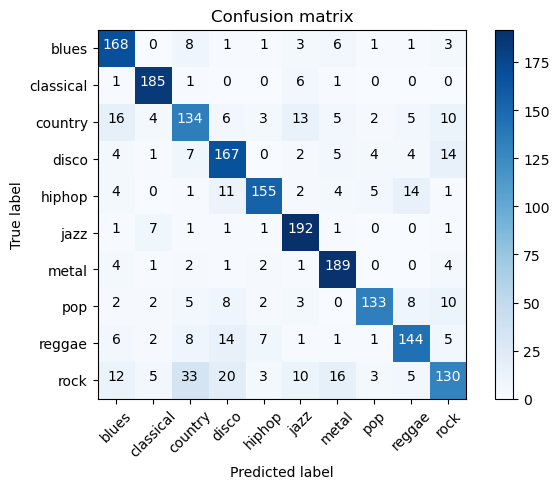

In [ ]:
cm = confusion_matrix(y_val,preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

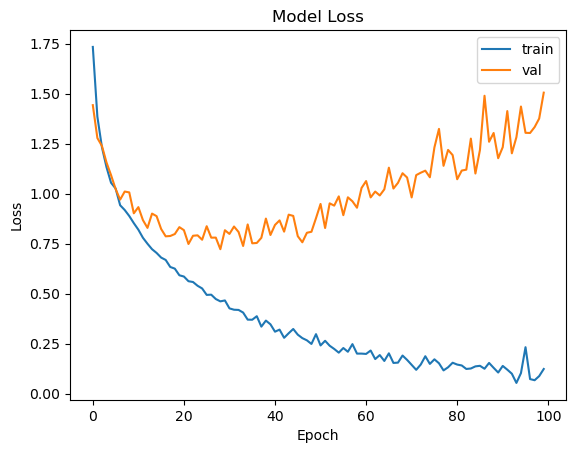

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

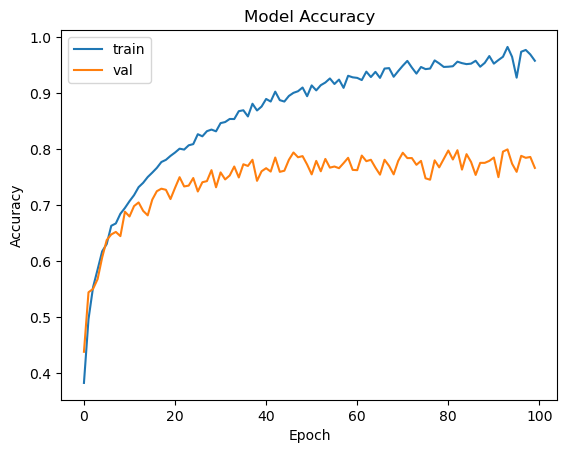

In [ ]:
# plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## LSTM + MFCS

In [ ]:
checkpoint = ModelCheckpoint('lstm_best_mfcs_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
# Define the input shape
input_shape = (26, 65, 1)

# Define the model
model = Sequential([
    Reshape((input_shape[0], input_shape[1] * input_shape[2]), input_shape=input_shape),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 26, 65)            0         
                                                                 
 lstm (LSTM)                 (None, 26, 64)            33280     
                                                                 
 dropout (Dropout)           (None, 26, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [ ]:
#history2 = model2.fit(X_train,y_train,batch_size=16,epochs=50,validation_data=(X_val, y_val))
history2 = model.fit(X_train,y_train,batch_size=16,epochs=250,validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/250
496/499 [============================>.] - ETA: 0s - loss: 0.8777 - accuracy: 0.7036
Epoch 1: val_accuracy did not improve from 0.59740
499/499 [==============================] - 3s 7ms/step - loss: 0.8793 - accuracy: 0.7028 - val_loss: 1.3867 - val_accuracy: 0.5824
Epoch 2/250
494/499 [============================>.] - ETA: 0s - loss: 0.8856 - accuracy: 0.7060
Epoch 2: val_accuracy did not improve from 0.59740
499/499 [==============================] - 4s 7ms/step - loss: 0.8844 - accuracy: 0.7065 - val_loss: 1.4398 - val_accuracy: 0.5764
Epoch 3/250
495/499 [============================>.] - ETA: 0s - loss: 0.8938 - accuracy: 0.7009
Epoch 3: val_accuracy did not improve from 0.59740
499/499 [==============================] - 4s 8ms/step - loss: 0.8928 - accuracy: 0.7010 - val_loss: 1.4400 - val_accuracy: 0.5784
Epoch 4/250
496/499 [============================>.] - ETA: 0s - loss: 0.8903 - accuracy: 0.6990
Epoch 4: val_accuracy did not improve from 0.59740
499/499 [======

In [ ]:
best_model = keras.models.load_model('bet_model.h5')

In [ ]:
pred = best_model.predict(X_val)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(y_val,preds,average='micro')
accuracy = accuracy_score(y_val,preds)
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")

63/63 [==============================] - 2s 9ms/step
The Test Accuracy is 0.6174261392088132 
 The F1 Score is 0.6174261392088132


In [ ]:
print(classification_report(y_val,preds,target_names=classes))

              precision    recall  f1-score   support

       blues       0.59      0.69      0.64       192
   classical       0.81      0.93      0.87       194
     country       0.44      0.48      0.46       198
       disco       0.57      0.49      0.52       208
      hiphop       0.65      0.59      0.62       197
        jazz       0.65      0.70      0.67       205
       metal       0.69      0.75      0.72       204
         pop       0.72      0.70      0.71       173
      reggae       0.60      0.54      0.57       189
        rock       0.44      0.35      0.39       237

    accuracy                           0.62      1997
   macro avg       0.62      0.62      0.62      1997
weighted avg       0.61      0.62      0.61      1997



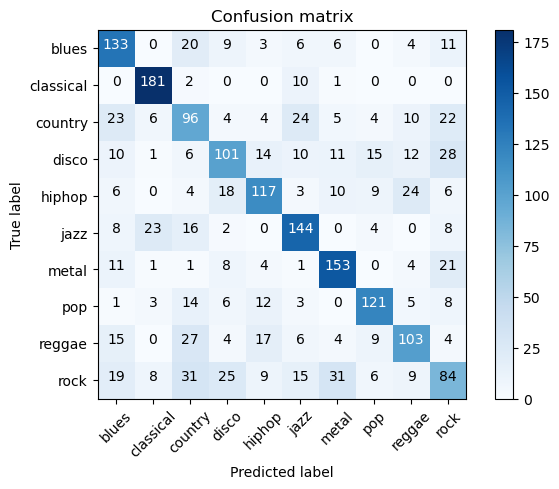

In [ ]:
cm = confusion_matrix(y_val,preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

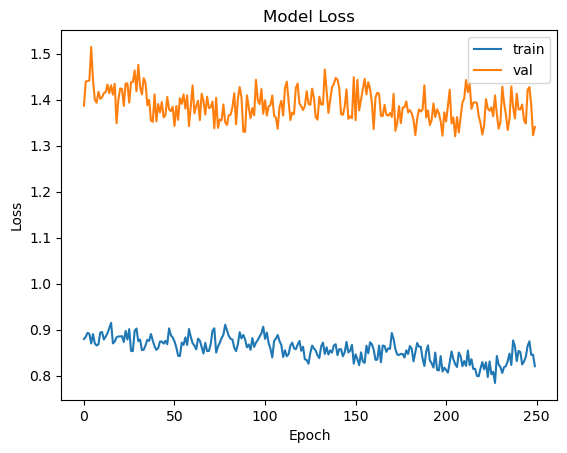

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

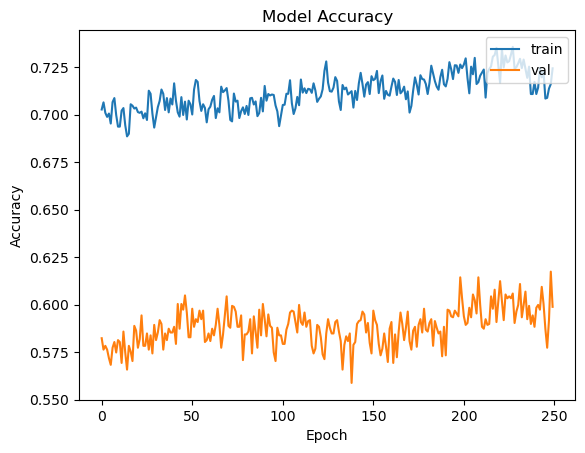

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Mel - Spectogram

## CNN 

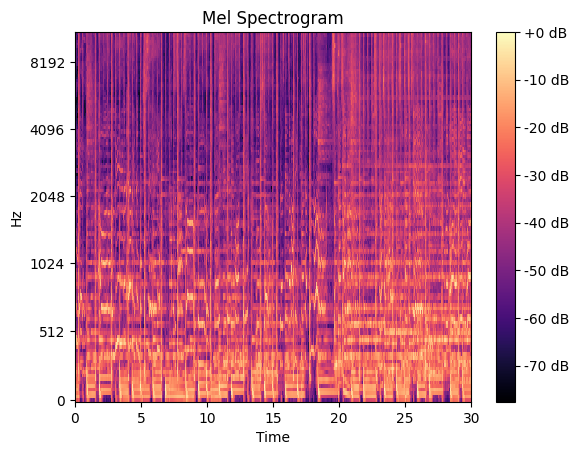

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio file
audio_file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/pop/pop.00034.wav'
signal, sr = librosa.load(audio_file)

# Compute mel spectrogram
n_fft = 2048
hop_length = 512
n_mels = 128
mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# Convert to decibels
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Display spectrogram
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


In [ ]:
images=[]
labels=[]
for i,audio_file in enumerate(audio_paths):
    # Compute mel spectrogram
    try:
        n_fft = 2048
        hop_length = 512
        n_mels = 128
        signal, sr = librosa.load(audio_file)
        
        segments = get_segments(signal, sr, segment_duration=3)
        
        for segment in segments:

            mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

            # Convert to decibels
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            images.append(mel_spec_db)
            genre = audio_file.split('/')[6]
            labels.append(genre)
    except Exception:
        pass 


/tmp/ipykernel_3987/1359269520.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(audio_file)


In [ ]:
import tensorflow as tf

model4 = tf.keras.models.Sequential([
    InputLayer(input_shape=(128, 130)),
    Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    Conv2D(256, (3, 3), padding='valid', activation='relu'),
    Conv2D(256, (3, 3), padding='valid', activation='relu'),
    AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
    Conv2D(256, (3, 3), padding='valid', activation='relu'),
    AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
    Conv2D(512, (4, 4), padding='valid', activation='relu'),
    GlobalAvgPool2D(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 128, 130, 1)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 126, 128, 256)     2560      
                                                                 
 conv2d_25 (Conv2D)          (None, 124, 126, 256)     590080    
                                                                 
 average_pooling2d_10 (Avera  (None, 62, 63, 256)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 61, 256)       590080    
                                                                 
 average_pooling2d_11 (Avera  (None, 30, 31, 256)      0         
 gePooling2D)                                         

In [ ]:
images=np.array(images)

In [ ]:

# convert text labels to int 
from sklearn.preprocessing import LabelEncoder
lbenc = LabelEncoder()
labels = lbenc.fit_transform(labels)

# split the data for training and testing
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(images,labels,test_size=0.2,
                                               shuffle=True,random_state=42)

In [ ]:

# check the shape and size of input and output data
print(X_train.shape, y_train.shape) # (num_samples, input_dim), (num_samples,)
print(X_val.shape, y_val.shape) 

(7984, 128, 130) (7984,)
(1997, 128, 130) (1997,)


In [ ]:
labels

array([3, 3, 3, ..., 7, 7, 7])

In [ ]:
X_train[1]

array([[-13.457714, -17.77913 , -19.967659, ..., -17.54917 , -18.21394 ,
        -19.956156],
       [-12.540745, -11.043556, -10.65497 , ..., -10.257536, -10.460773,
        -12.581396],
       [-16.270845, -12.082106, -11.410883, ..., -14.282682, -14.307522,
        -13.719681],
       ...,
       [-50.965473, -50.50724 , -52.200104, ..., -54.38601 , -55.52249 ,
        -54.83252 ],
       [-51.901817, -50.12827 , -50.965736, ..., -52.525387, -56.112568,
        -59.724396],
       [-51.98068 , -50.661125, -52.603603, ..., -54.338898, -55.694885,
        -59.77806 ]], dtype=float32)

In [ ]:
# set up a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
history = model4.fit(X_train,y_train,batch_size=16,epochs=100,validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/100
499/499 [==============================] - ETA: 0s - loss: 2.1981 - accuracy: 0.1618
Epoch 1: val_accuracy improved from 0.09614 to 0.22384, saving model to best_model.h5
499/499 [==============================] - 51s 98ms/step - loss: 2.1981 - accuracy: 0.1618 - val_loss: 1.9656 - val_accuracy: 0.2238
Epoch 2/100
499/499 [==============================] - ETA: 0s - loss: 1.9712 - accuracy: 0.2301
Epoch 2: val_accuracy improved from 0.22384 to 0.24637, saving model to best_model.h5
499/499 [==============================] - 46s 93ms/step - loss: 1.9712 - accuracy: 0.2301 - val_loss: 1.9177 - val_accuracy: 0.2464
Epoch 3/100
499/499 [==============================] - ETA: 0s - loss: 1.8936 - accuracy: 0.2762
Epoch 3: val_accuracy improved from 0.24637 to 0.35603, saving model to best_model.h5
499/499 [==============================] - 46s 93ms/step - loss: 1.8936 - accuracy: 0.2762 - val_loss: 1.7832 - val_accuracy: 0.3560
Epoch 4/100
499/499 [==============================]

In [ ]:
import keras

In [ ]:
from sklearn.metrics import f1_score,accuracy_score

In [ ]:
best_model = keras.models.load_model('/kaggle/input/cnn-mel2/best_model_MEL_SPECTOGRAM.h5')

In [ ]:
pred = best_model.predict(X_val)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(y_val,preds,average='micro')
accuracy = accuracy_score(y_val,preds)
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")#

63/63 [==============================] - 3s 44ms/step
The Test Accuracy is 0.8883324987481221 
 The F1 Score is 0.8883324987481221


In [ ]:
print(classification_report(y_val,preds,target_names=classes))

              precision    recall  f1-score   support

       blues       0.82      0.92      0.87       192
   classical       0.94      0.95      0.95       194
     country       0.77      0.88      0.82       198
       disco       0.94      0.87      0.90       208
      hiphop       0.95      0.92      0.94       197
        jazz       0.93      0.94      0.93       205
       metal       0.92      0.98      0.95       204
         pop       0.87      0.87      0.87       173
      reggae       0.92      0.89      0.90       189
        rock       0.84      0.70      0.77       237

    accuracy                           0.89      1997
   macro avg       0.89      0.89      0.89      1997
weighted avg       0.89      0.89      0.89      1997



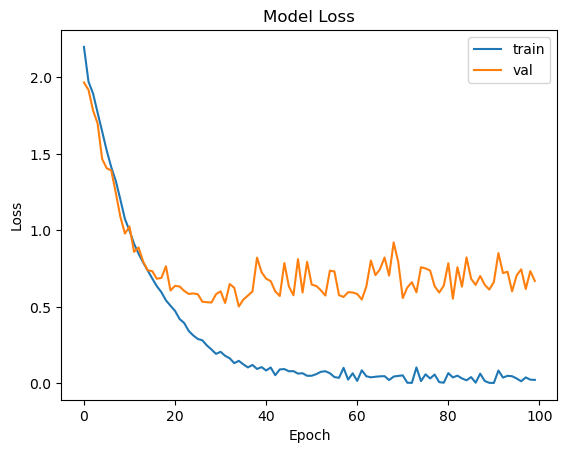

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

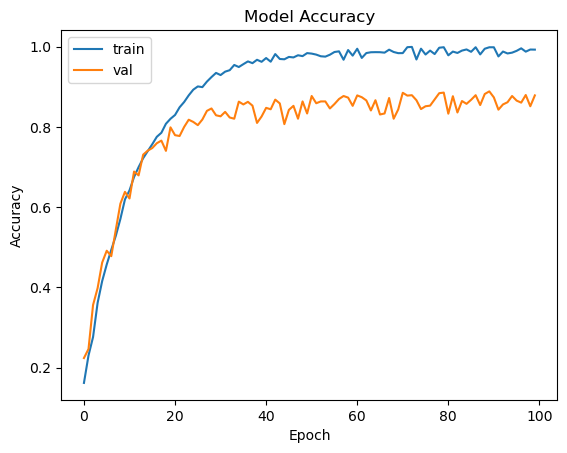

In [ ]:
# plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_val,preds)

In [ ]:
classes= lbenc.classes_

In [ ]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

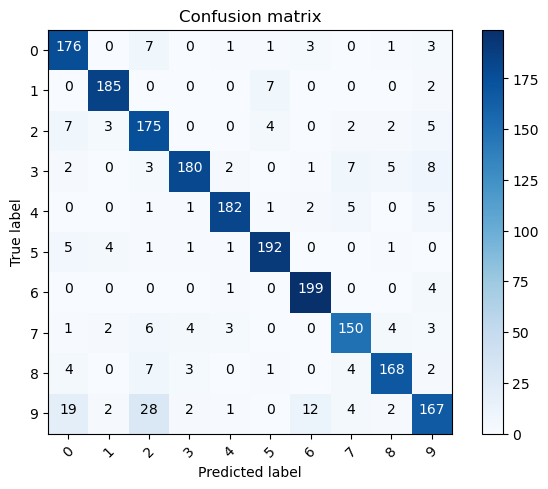

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## DenseNet121

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.applications.densenet import DenseNet121

input_shape = (128, 130, 1) # input shape of spectrogram images
num_classes = 10 # number of music genres

# build DenseNet121 base model
input_layer = Input(shape=input_shape)
x = Reshape(target_shape=(input_shape[0], input_shape[1], 1))(input_layer)
base_model = DenseNet121(input_shape=(input_shape[0], input_shape[1], 1), weights=None, include_top=False)(x)

# add classification head
x = Flatten()(base_model)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# create model
model = Model(inputs=input_layer, outputs=predictions)

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 130, 1)]     0         
                                                                 
 reshape (Reshape)           (None, 128, 130, 1)       0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7031232   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1024)              16778240  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800

In [ ]:
history = model.fit(X_train,y_train,batch_size=16,epochs=100,validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/100
499/499 [==============================] - ETA: 0s - loss: 2.9070 - accuracy: 0.2211
Epoch 1: val_accuracy did not improve from 0.09865
499/499 [==============================] - 121s 86ms/step - loss: 2.9070 - accuracy: 0.2211 - val_loss: 6.1777 - val_accuracy: 0.0956
Epoch 2/100
499/499 [==============================] - ETA: 0s - loss: 1.8900 - accuracy: 0.2961
Epoch 2: val_accuracy improved from 0.09865 to 0.26990, saving model to best_model.h5
499/499 [==============================] - 42s 85ms/step - loss: 1.8900 - accuracy: 0.2961 - val_loss: 3.0555 - val_accuracy: 0.2699
Epoch 3/100
499/499 [==============================] - ETA: 0s - loss: 1.6681 - accuracy: 0.3786
Epoch 3: val_accuracy did not improve from 0.26990
499/499 [==============================] - 41s 81ms/step - loss: 1.6681 - accuracy: 0.3786 - val_loss: 10.5248 - val_accuracy: 0.1948
Epoch 4/100
499/499 [==============================] - ETA: 0s - loss: 1.5214 - accuracy: 0.4438
Epoch 4: val_accuracy d

In [ ]:
best_model = keras.models.load_model('best_model.h5')

In [ ]:
pred = best_model.predict(X_val)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(y_val,preds,average='micro')
accuracy = accuracy_score(y_val,preds)
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")

63/63 [==============================] - 4s 24ms/step
The Test Accuracy is 0.900851276915373 
 The F1 Score is 0.900851276915373


In [ ]:
print(classification_report(y_val,preds,target_names=classes))

              precision    recall  f1-score   support

       blues       0.96      0.90      0.93       192
   classical       0.90      0.98      0.94       194
     country       0.84      0.88      0.86       198
       disco       0.90      0.85      0.87       208
      hiphop       0.88      0.94      0.91       197
        jazz       0.94      0.97      0.95       205
       metal       0.96      0.95      0.95       204
         pop       0.83      0.93      0.87       173
      reggae       0.90      0.89      0.90       189
        rock       0.90      0.75      0.82       237

    accuracy                           0.90      1997
   macro avg       0.90      0.90      0.90      1997
weighted avg       0.90      0.90      0.90      1997



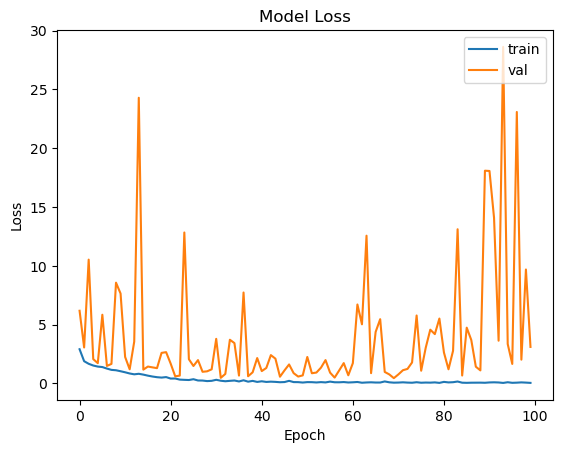

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

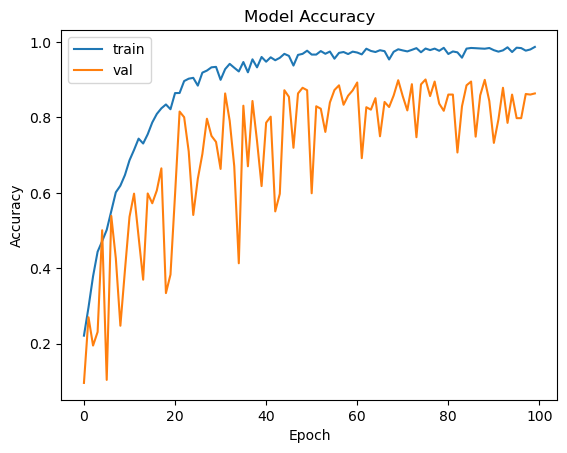

In [ ]:
# plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cm = confusion_matrix(y_val,preds)

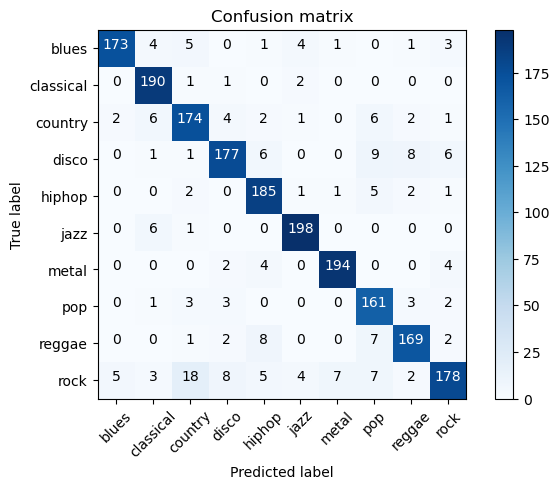

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## CNN + RNN

In [ ]:
model.add(Reshape((128, 130, 1), input_shape=(1280, 130)))


In [ ]:

# Define the input shape
input_shape = (128, 130)

# Create an input tensor
inputs = Input(shape=input_shape)
x = Reshape((128, 130, 1))(inputs)

# Add a series of convolutional and pooling layers
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Add an LSTM layer
x = Reshape((-1, 256))(x)
x = LSTM(64)(x)

# Add a dense output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 128, 130)]        0         
                                                                 
 reshape_21 (Reshape)        (None, 128, 130, 1)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 126, 128, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 61, 62, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 30, 31, 64)       0         
 g2D)                                                      

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
history = model.fit(X_train,y_train,batch_size=16,epochs=100,validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/100
498/499 [============================>.] - ETA: 0s - loss: 2.3168 - accuracy: 0.1007
Epoch 1: val_accuracy improved from -inf to 0.15023, saving model to best_model.h5
499/499 [==============================] - 8s 11ms/step - loss: 2.3166 - accuracy: 0.1007 - val_loss: 2.3174 - val_accuracy: 0.1502
Epoch 2/100
496/499 [============================>.] - ETA: 0s - loss: 2.1991 - accuracy: 0.1749
Epoch 2: val_accuracy improved from 0.15023 to 0.28493, saving model to best_model.h5
499/499 [==============================] - 5s 10ms/step - loss: 2.1982 - accuracy: 0.1752 - val_loss: 1.9723 - val_accuracy: 0.2849
Epoch 3/100
497/499 [============================>.] - ETA: 0s - loss: 1.8682 - accuracy: 0.3097
Epoch 3: val_accuracy improved from 0.28493 to 0.36705, saving model to best_model.h5
499/499 [==============================] - 5s 10ms/step - loss: 1.8667 - accuracy: 0.3104 - val_loss: 1.7008 - val_accuracy: 0.3671
Epoch 4/100
498/499 [============================>.] - ETA

In [ ]:
best_model = keras.models.load_model('/kaggle/input/cnn-rnn/CNNRNN_MEL.h5')

In [ ]:
pred = best_model.predict(X_val)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(y_val,preds,average='micro')
accuracy = accuracy_score(y_val,preds)
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")

63/63 [==============================] - 1s 4ms/step
The Test Accuracy is 0.8187280921382073 
 The F1 Score is 0.8187280921382074


In [ ]:
print(classification_report(y_val,preds,target_names=classes))

              precision    recall  f1-score   support

       blues       0.78      0.83      0.80       192
   classical       0.88      0.93      0.91       194
     country       0.68      0.71      0.69       198
       disco       0.87      0.82      0.85       208
      hiphop       0.88      0.89      0.89       197
        jazz       0.82      0.90      0.86       205
       metal       0.96      0.87      0.91       204
         pop       0.79      0.83      0.81       173
      reggae       0.84      0.83      0.84       189
        rock       0.70      0.61      0.65       237

    accuracy                           0.82      1997
   macro avg       0.82      0.82      0.82      1997
weighted avg       0.82      0.82      0.82      1997



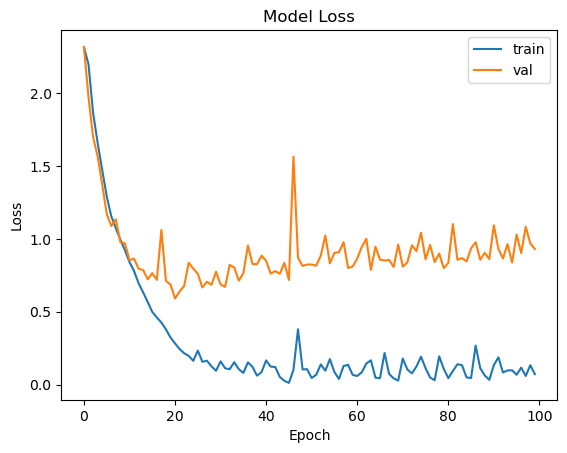

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

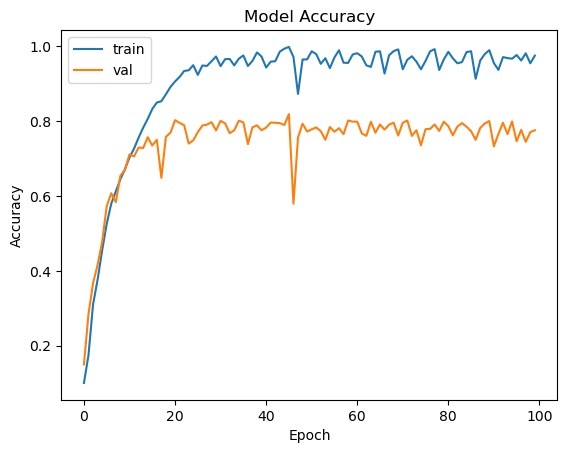

In [ ]:
# plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cm = confusion_matrix(y_val,preds)

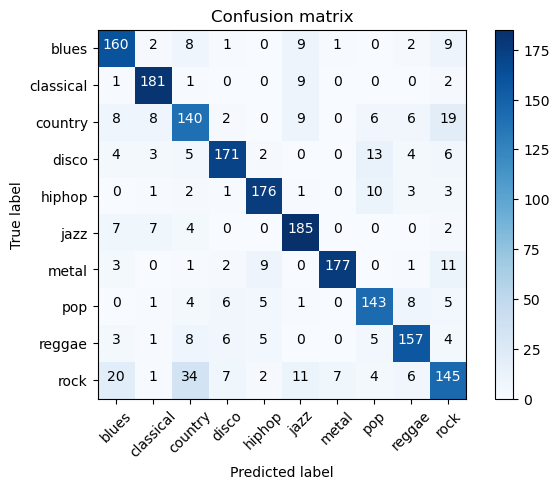

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()